In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# load Data

In [2]:
data = pd.read_csv("housing.csv")
data.dropna(inplace=True)

X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Visualization Before Modeling 

a) Histogram

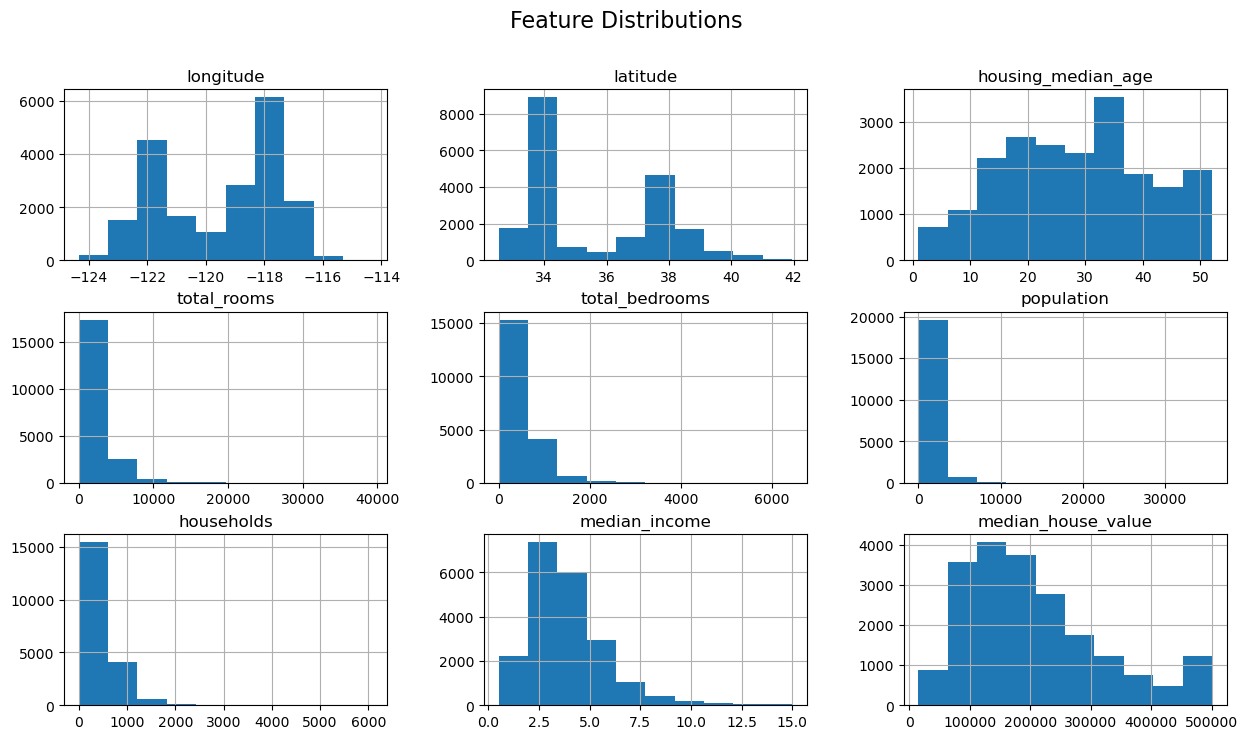

In [3]:
data.hist(figsize=(15, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

b) Correlation Heatmap


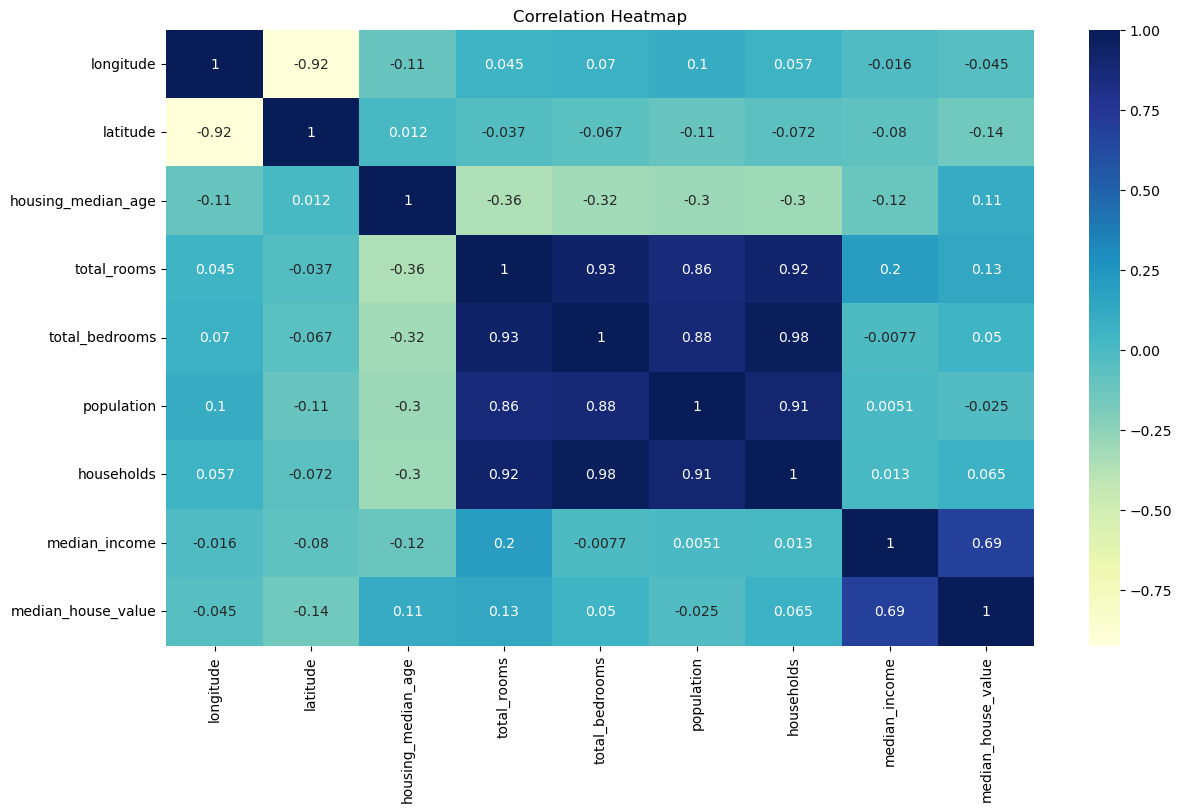

In [4]:
plt.figure(figsize=(14, 8))
sns.heatmap(data.select_dtypes(include=['int64', 'float64']).corr(),
            annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()



c) Scatterplot: Latitude vs Longitude

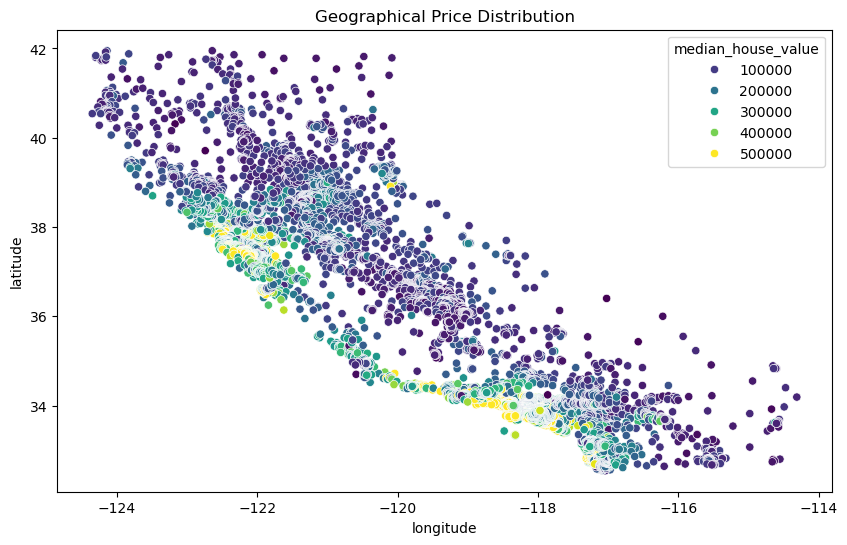

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data["longitude"], y=data["latitude"],
                hue=data["median_house_value"], palette="viridis")
plt.title("Geographical Price Distribution")
plt.show()

# Custom Feature Engineering


In [6]:
def add_custom_features(df):
    df = df.copy()

    # Log transforms
    df["total_rooms"] = np.log(df["total_rooms"] + 1)
    df["total_bedrooms"] = np.log(df["total_bedrooms"] + 1)
    df["population"] = np.log(df["population"] + 1)
    df["households"] = np.log(df["households"] + 1)

    # Feature engineering
    df["bedroom_ratio"] = df["total_bedrooms"] / df["total_rooms"]
    df["household_rooms"] = df["total_rooms"] / df["households"]

    return df

feature_engineering = FunctionTransformer(add_custom_features)

# Define Column Types

In [7]:
numeric_features = [
    "longitude", "latitude", "housing_median_age",
    "total_rooms", "total_bedrooms", "population",
    "households", "median_income",
    "bedroom_ratio", "household_rooms"
]

categorical_features = ["ocean_proximity"]

#  Preprocessing Pipeline

In [8]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Full Pipelines


In [9]:
lin_reg_pipeline = Pipeline([
    ("features", feature_engineering),
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

forest_pipeline = Pipeline([
    ("features", feature_engineering),
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

# Train Models

In [10]:
lin_reg_pipeline.fit(X_train, y_train)
forest_pipeline.fit(X_train, y_train)

print("Linear Regression Score:", lin_reg_pipeline.score(X_test, y_test))
print("Random Forest Score:", forest_pipeline.score(X_test, y_test))

Linear Regression Score: 0.6687407117584969
Random Forest Score: 0.8190895572460393


# Grid Search on Random Forest

In [11]:
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__min_samples_split": [2, 4],
    "model__max_depth": [None, 4, 8]
}

grid_search = GridSearchCV(
    forest_pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Model Score:", best_model.score(X_test, y_test))

Best Model Score: 0.8219931364186497


# Visualization After Modeling


 Residual Plot (Linear Regression)

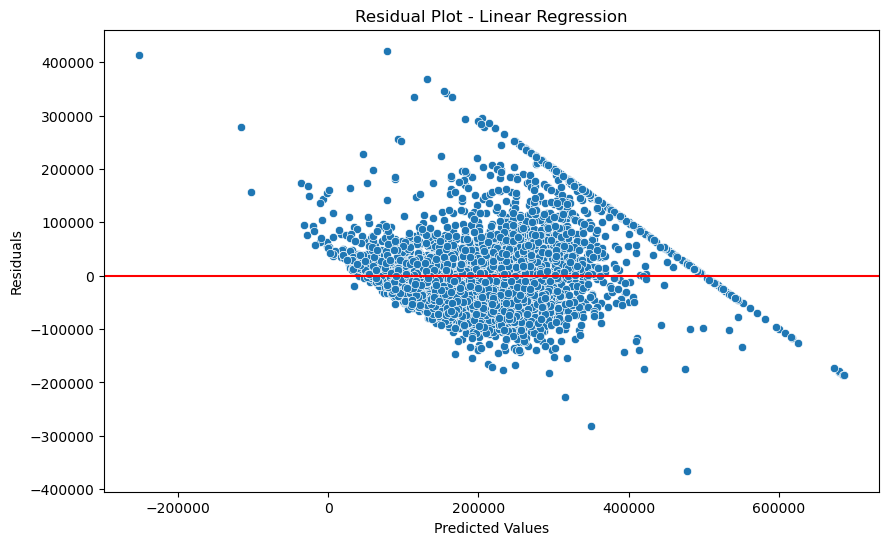

In [12]:
y_pred_lr = lin_reg_pipeline.predict(X_test)
residuals = y_test - y_pred_lr

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, color='red')
plt.title("Residual Plot - Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Feature Importance (Random Forest)

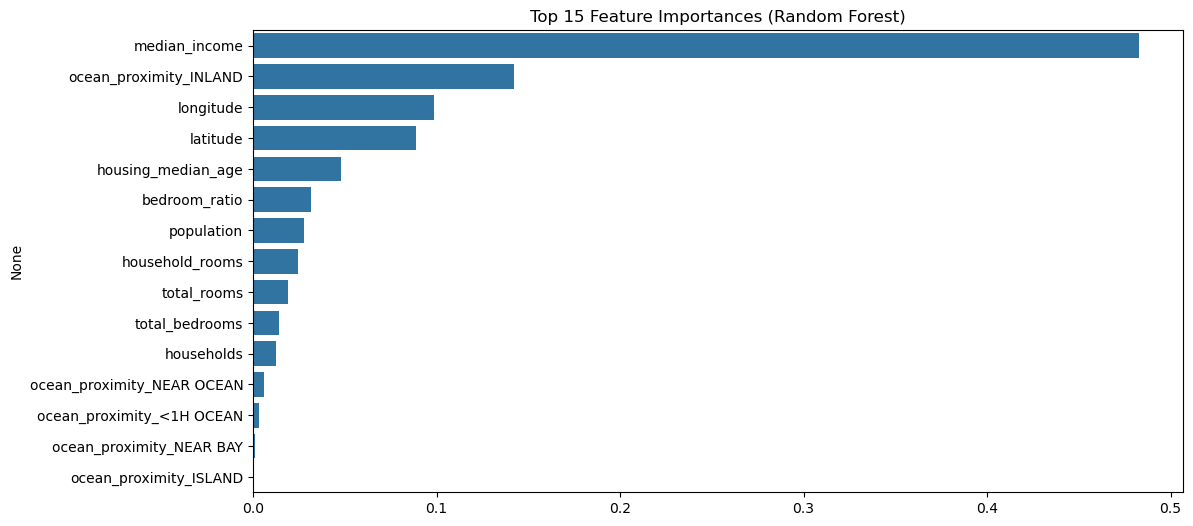

In [13]:
rf_model = best_model.named_steps["model"]
importances = rf_model.feature_importances_

ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_features)

all_features = numeric_features + list(ohe_features)

feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

Save Final Model

In [14]:
joblib.dump(best_model, "final_housing_model.pkl")
print(" Model saved as final_housing_model.pkl")

 Model saved as final_housing_model.pkl


In [15]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [18]:
best_model.named_steps['preprocess'].feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'bedroom_ratio', 'household_rooms'],
      dtype=object)

In [23]:
best_model.named_steps['preprocess'].transformers_[1][1].categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]